In [4]:
from pathlib import Path
import sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'
os.environ['HF_HUB_CACHE'] = '/next_share/hf_cache/hub'
import json
import numpy as np
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, BitsAndBytesConfig, AutoModelForCausalLM, LlamaForCausalLM, PreTrainedModel, AutoModelForSeq2SeqLM
from peft import get_peft_model, LoraConfig, get_peft_model_state_dict, AutoPeftModelForCausalLM, load_peft_weights
import importlib
import difflib
from collections import defaultdict

import context
os.chdir(context.proj_dir)

import cont_gen
import cont_gen.data_process.pre_process.split_long_para
import cont_gen.utils.model_utils
_ = importlib.reload(cont_gen.data_process.pre_process.split_long_para)
importlib.reload(cont_gen.utils.model_utils)
from cont_gen.data_loader.cuad_sft import CUAD_SFT_Cached
from cont_gen.utils.model_utils import load_hf_model_from_checkpoint

# Overview

1. [Link](#model-initialize) Explore model initialize.
   1. Q-lora
   2. Device map
   3. Show dataset
   4. [Link](#lora-demo) Lora demo
2. [Link](#explore-memory-usage) Explore the memory usage
3. [Link](#gradient-checkpointing) Explore gradient checkpointing
4. Explore how to adapt to chat model, e.g., llama2-chat and llama3-instruct.

## Model Initialize

In [2]:
def get_device_map(model_name):
    if torch.cuda.device_count() == 2:
        if any([k in model_name for k in ['llama', 'mistral']]):
            device_map = {
                'model.embed_tokens': 0,
                'model.norm': 1,
                'lm_head': 1
            }
            device_map.update({f'model.layers.{i}': 0 if i < 16 else 1 for i in range(32)})
        else:
            device_map = 'auto'
    elif torch.cuda.device_count() == 1:
        device_map = {"":0}
    else:
        device_map = 'auto'
    return device_map

model_names = {'llama3': 'meta-llama/Meta-Llama-3-8B',
               'mistral': 'mistralai/Mistral-7B-v0.1',
               'llama2': 'meta-llama/Llama-2-7b-hf',
               'flan-t5-xl': 'google/flan-t5-xl'}

In [3]:
# This quantization config is for QLora
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model_name = model_names['llama3']
# model_name = 'bert-base-uncased'
mod_cls = AutoModelForSeq2SeqLM if 't5' in model_name else AutoModelForCausalLM
model = mod_cls.from_pretrained(
    model_name,
    cache_dir = '/next_share/hf_cache/hub',
    device_map = get_device_map(model_name),
    torch_dtype = torch.bfloat16,
    # quantization_config = quant_config
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
del model

### Model Device Map

**Mistral**:
- modules (GB):
  - 'model.embed_tokens': 0.1311
  - 'model.layers.{0..31}': 0.2181
  - 'model.norm': 0
  - 'lm_head': 0.1311
- Tie: False
- Device map:
  - emb: 0
  - layers 0-15: 0
  - layers 16-31: 1
  - norm, lm_head: 1

**LLaMA 3**:
- modules:
  - 'model.embed_tokens': 0.5253
  - 'model.layers.{0..31}': 0.2181
  - 'model.norm': 0
  - 'lm_head': 0.5253
- Tie: False
- Device map:
  - emb: 0
  - layers 0-13: 0
  - layers 14-31: 1
  - norm, lm_head: 1
- Difference: 4 layers, 0.88B, 1.8GB, Real: 7777 vs 9457 MB

**LLaMA2**:
- modules:
  - 'model.embed_tokens': 0.1311
  - 'model.layers.{0..31}': 0.2024
- Device map: same as mistral. layers are equally divided.

In [8]:
# model.hf_device_map

In [4]:
def num_el(mod, exp = 3):
    """get number of parameters. exp=3 means returning in Billion"""
    tot_p = sum(p.numel() for p in mod.parameters())
    # print(tot_p)
    return tot_p / (1000**exp)

In [5]:
print(num_el(model))

2.849757184


In [6]:
# Print the parameter number of sub modules
n2mod = {k:v for k,v in model.named_modules()}
np_emb = num_el(n2mod['model.embed_tokens'])
np_layer = num_el(n2mod['model.layers.0'])
np_norm = num_el(n2mod['model.norm'])
np_head = num_el(n2mod['lm_head'])
print([f'{k:.4f}' for k in [np_emb, np_layer, np_norm, np_head]])
print(model.get_output_embeddings() is model.get_input_embeddings())

['0.1311', '0.2024', '0.0000', '0.1311']
False


In [7]:
# Validate total parameter number
tot_add = np_emb + np_layer * 32 + np_head
print(tot_add)
print(num_el(model))

6.73841152
6.738415616


### Lora Demo

In [4]:
peft_config = LoraConfig(
    r = 16, lora_alpha = 16,
    # target_modules = None,
    target_modules = 'all-linear',
    lora_dropout= 0.1,
    bias = "none"
)

lora_model = get_peft_model(model, peft_config)
lora_model.print_trainable_parameters()

trainable params: 41,943,040 || all params: 8,072,204,288 || trainable%: 0.5195983464188562


In [9]:
# lora_model.save_pretrained('runs/debug/lora_ckpt')

### Dataset

In [8]:
tk_mistral = AutoTokenizer.from_pretrained(model_names['mistral'], cache_dir = '/next_share/hf_cache/hub')
tk_llama3 = AutoTokenizer.from_pretrained(model_names['llama3'], cache_dir = '/next_share/hf_cache/hub')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
data_path = 'data/ood_split/seed128_tr29/mistral/pmt_01_yes_no/train_data.jsonl'
dataset = CUAD_SFT_Cached(
    data_path,
    tk_mistral,
    is_seq2seq = False,
    cache_dir = Path(data_path).parent / 'cache',
    max_src_length = None,
    max_tgt_length = None,
    labels_on_full = False,
    is_test = False,
    small = False
)

Load from cache: data/ood_split/seed128_tr29/mistral/pmt_01_yes_no/cache/cached_train_data.jsonl_Mistral-7B-v0.1_v1.0.pkl


In [16]:
ipt_lens = [len(k['input_ids']) for k in dataset]
print(max(ipt_lens))

1117


In [19]:
max_i = np.argmax(ipt_lens)
d = dataset.data[max_i]
# print(d['source'])

In [21]:
dataset[0]['input_ids'][-10:]

[28723, 387, 12751, 4572, 23148, 1017, 14778, 8472, 7178, 2]

In [25]:
tk_mistral.unk_token_id

0

## Explore Memory Usage

In [23]:
model = AutoModelForCausalLM.from_pretrained('gpt2', cache_dir = '/next_share/hf_cache/hub').cuda()

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [5]:
from pynvml import *

class NVML_Mem:
    def __init__(self, gpu_indexes = None):
        self.gpu_indexes = gpu_indexes if gpu_indexes is not None else \
                    [int(k) for k in os.environ['CUDA_VISIBLE_DEVICES'].split(',')]
        nvmlInit()
    
    def __call__(self):
        return [self.get_mem_by_id(k) for k in self.gpu_indexes]
    
    def get_mem_by_id(self, index):
        h = nvmlDeviceGetHandleByIndex(index)
        info = nvmlDeviceGetMemoryInfo(h)
        return info.used / 1024**3
    

def get_mem_of_len(ipt_len, model, gpu_ids, optimizer):
    """Return Memory of all gpus in GiB"""
    input_ids = torch.tensor([1]*ipt_len).cuda().unsqueeze(0)
    optimizer.zero_grad()
    loss = model(input_ids, labels = input_ids).loss
    loss.backward()
    optimizer.step()
    return NVML_Mem(gpu_ids)()

def get_infer_mem_of_len(ipt_len, model, gpu_ids):
    """Return Memory of all gpus in GiB"""
    input_ids = torch.tensor([1]*ipt_len).cuda().unsqueeze(0)
    with torch.no_grad():
        loss = model(input_ids, labels = input_ids).loss
    
    return NVML_Mem(gpu_ids)()

def scan_mem(step, num_steps, model, gpu_ids):
    optimizer = torch.optim.AdamW(model.parameters())
    memorys = [NVML_Mem(gpu_ids)()]
    for step_i in range(1, num_steps + 1):
        memorys.append(get_mem_of_len(step * step_i, model, gpu_ids, optimizer))
    return memorys

def scan_mem_infer(step, num_steps, model, gpu_ids = None):
    memorys = [NVML_Mem(gpu_ids)()]
    for step_i in range(1, num_steps + 1):
        memorys.append(get_infer_mem_of_len(step * step_i, model, gpu_ids))
    return memorys

In [7]:
lora_model.gradient_checkpointing_disable()
n_steps = 6
memory_list = scan_mem(128, n_steps, model, [int(k) for k in os.environ['CUDA_VISIBLE_DEVICES'].split(',')])
print(memory_list)

[[15.52020263671875, 15.65301513671875], [15.52020263671875, 15.65301513671875], [15.52020263671875, 15.65301513671875], [15.52020263671875, 15.65301513671875], [15.52020263671875, 15.65301513671875], [15.52020263671875, 15.65301513671875], [15.88739013671875, 15.65301513671875]]


In [6]:
lora_model.enable_input_require_grads()
lora_model.gradient_checkpointing_enable()

In [8]:
res = []
for k,v in lora_model.named_modules():
    if hasattr(v, "gradient_checkpointing"):
        res.append((v, v.gradient_checkpointing))
print(len(res))

1


In [10]:
# Memory for Gradient Checkpointing

n_steps = 6
memory_list = scan_mem(128, n_steps, lora_model, [int(k) for k in os.environ['CUDA_VISIBLE_DEVICES'].split(',')])
print(memory_list)

[[8.46356201171875, 8.46356201171875], [9.55535888671875, 9.73114013671875], [10.45965576171875, 10.76824951171875], [11.42840576171875, 11.89520263671875], [12.36395263671875, 12.97528076171875], [13.53387451171875, 14.24481201171875], [15.55340576171875, 15.65301513671875]]


In [15]:
torch.cuda.empty_cache()

In [16]:
NVML_Mem()()

[9.04168701171875, 8.99871826171875]

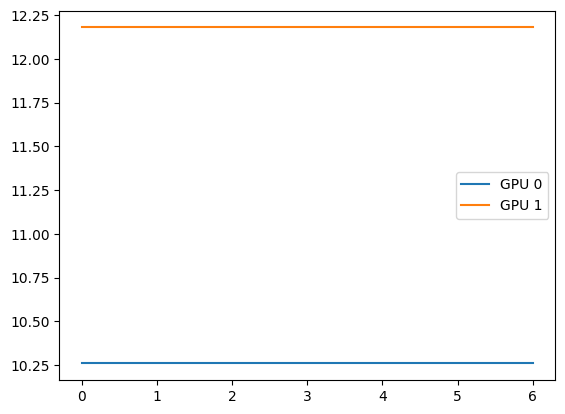

In [14]:
import matplotlib.pyplot as plt

x = np.arange(n_steps + 1)
mems = np.array(memory_list)
for col in range(mems.shape[1]):
    plt.plot(x, mems[:,col], color = f'C{col}', label = f'GPU {col}')
# plt.plot(x, mems[:,1], color = 'g')
plt.legend()

In [12]:
k = (mems[-1,0] - mems[0, 0]) / n_steps
print(k)

1.3583984375


In [10]:
incre = mems[1:,0] - mems[:-1,0]
print(incre)

[0.73828125 0.8515625  0.95117188 0.84765625 1.23242188 2.13867188
 1.734375   2.37304688]


[[15.709716796875], [15.947998046875], [16.199951171875], [16.600341796875], [17.092529296875], [17.705810546875], [18.440185546875], [19.297607421875], [20.278076171875]]


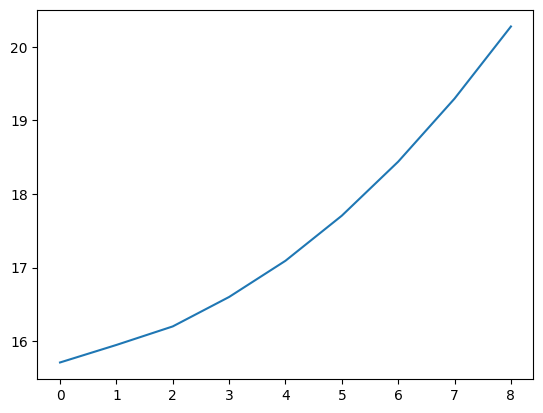

In [7]:
# inference mem
n_steps = 8
infer_memory_list = scan_mem_infer(128, n_steps, model, [int(k) for k in os.environ['CUDA_VISIBLE_DEVICES'].split(',')])
print(infer_memory_list)

import matplotlib.pyplot as plt

x = np.arange(n_steps + 1)
mems = np.array(infer_memory_list)
for col in range(mems.shape[1]):
    plt.plot(x, mems[:,col], color = f'C{col}')

In [9]:
r = model.generate(input_ids = torch.tensor([1]*512).cuda().unsqueeze(0),max_new_tokens = 512, eos_token_id = -1)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:-1 for open-end generation.


In [10]:
tk_llama3.batch_decode(r)[0]

'"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""" ( =>000 (r\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\\def\

In [11]:
len(r[0])

1024

## Gradient Checkpointing

In [5]:
def train_loop(model, steps, input_len = 1024):
    input_ids = torch.tensor([1]*input_len).cuda().unsqueeze(0)
    optimizer = torch.optim.AdamW(model.parameters())
    for _ in tqdm(list(range(steps))):
        optimizer.zero_grad()
        loss = model(input_ids, labels = input_ids).loss
        loss.backward()
    optimizer.step()

In [8]:
print(NVML_Mem()())
lora_model.gradient_checkpointing_enable()
train_loop(model, 20, input_len = 1122)
NVML_Mem()()

[8.129638671875, 8.129638671875]


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


[17.697998046875, 19.094482421875]

In [7]:
model.gradient_checkpointing_disable()
train_loop(model, 20, input_len = 1122)
NVML_Mem()()

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 112.00 MiB (GPU 0; 22.19 GiB total capacity; 20.73 GiB already allocated; 77.31 MiB free; 21.17 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [6]:
import numpy as np
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import TrainingArguments, Trainer

seq_len, dataset_size = 512, 16
dummy_data = {
    "input_ids": np.random.randint(100, 30000, (dataset_size, seq_len)),
}
dummy_data['labels'] = dummy_data['input_ids']
ds = Dataset.from_dict(dummy_data)
ds.set_format("pt")

print(NVML_Mem()())

default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none",
    'remove_unused_columns': False
}

[0.30340576171875, 0.30340576171875]


In [7]:
lora_model.enable_input_require_grads()

In [7]:
training_args = TrainingArguments(
    per_device_train_batch_size=1, 
    gradient_checkpointing=True,
    **default_args
)
trainer = Trainer(model=lora_model, args=training_args, train_dataset=ds)

# tr_dl = trainer.get_train_dataloader()
# result = trainer.train()

print(NVML_Mem()())

NameError: name 'lora_model' is not defined

In [9]:
trainer.model.gradient_checkpointing_enable()

In [8]:
training_args.parallel_mode

<ParallelMode.NOT_DISTRIBUTED: 'not_distributed'>

In [29]:
import transformers
transformers.__version__

'4.36.2'

### Load PEFT

In [10]:
peft_id = 'runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_bs16_wd0.0/checkpoint-15692'
# model = AutoModelForCausalLM.from_pretrained(
#     peft_id, 
#     cache_dir = '/next_share/hf_cache/hub')

In [11]:
st = torch.load(Path(peft_id) / 'adapter_model.bin', map_location = 'cpu')

In [12]:
print([k for k in st.keys() if 'layer' not in k])

[]


In [13]:
len(st)

448

In [3]:
from accelerate import Accelerator

model = load_hf_model_from_checkpoint(peft_id, Accelerator(), 'bf16')

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Resize embedding num to 128257


In [9]:
gen_r = model.generate()

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [10]:
tk_llama3.batch_decode(gen_r)[0]

'<|begin_of_text|>Question:\nWhat is the greatest common factor of 126 and 105?\nAnswer:\n21<|end_of_text|>'

In [16]:
tk_llama3.pad_token = tk_llama3.eos_token
print(tk_llama3.pad_token)
print(tk_llama3.pad_token_id)
print(len(tk_llama3))

<|end_of_text|>
128001
128256


In [37]:
ipt_emb = model.get_input_embeddings()
ipt_emb_n, ipt_emb_w = list(ipt_emb.named_parameters())[0]
print(ipt_emb_n)
print(ipt_emb_w.shape)

weight
torch.Size([50257, 768])


In [32]:
for n,m in model.named_modules():
    if m is model.get_input_embeddings():
        print(n)

transformer.wte


In [34]:
st = load_peft_weights(peft_id)
keys = list(st.keys())

In [36]:
keys[-2:]

['base_model.model.model.embed_tokens.weight',
 'base_model.model.lm_head.weight']

In [6]:
torch.cuda.empty_cache()